In [27]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image

In [12]:
REL_IMAGE_PATH = "../data/images-256/"
REL_MASK_PATH = "../data/masks-256/"
image_names = os.listdir(REL_IMAGE_PATH)

In [9]:
#creating U-Net architecture
def create_model(width, height, channel):
    inputs = tf.keras.layers.Input((width,height,channel))
    s = tf.keras.layers.Lambda(lambda x : x/255)(inputs)
    c1 = tf.keras.layers.Conv2D(16,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(s)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

    c2 = tf.keras.layers.Conv2D(32,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

    c3 = tf.keras.layers.Conv2D(64,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

    c4 = tf.keras.layers.Conv2D(128,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c4)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)


    c5 = tf.keras.layers.Conv2D(256,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c5)


    u6 = tf.keras.layers.Conv2DTranspose(128,(2,2),strides = (2,2),padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6,c4])
    c6 = tf.keras.layers.Conv2D(128,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(u6)
    c6 = tf.keras.layers.Dropout(0.3)(c6)
    c6 = tf.keras.layers.Conv2D(128,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64,(2,2),strides = (2,2),padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7,c3])
    c7 = tf.keras.layers.Conv2D(64,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32,(2,2),strides = (2,2),padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8,c2])
    c8 = tf.keras.layers.Conv2D(32,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(64,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16,(2,2),strides = (2,2),padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9,c1],axis = 3)
    c9 = tf.keras.layers.Conv2D(16,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c9)

    outputs = tf.keras.layers.Conv2D(1,(1,1),activation = "sigmoid")(c9)

    model = tf.keras.Model(inputs = [inputs],outputs = [outputs])
    model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics = ['accuracy'])
    #model.summary()
    return model

In [10]:
model = create_model(128, 128, 3)

In [11]:
model.load_weights("./mode_name.h5")

In [127]:
def predict_and_show_random_images(model, n):
    fig, ax = plt.subplots(n, 2, sharey='row', figsize = (2*n,4*n))
    
    images_to_predict = np.zeros((n,128,128,3),dtype = np.uint8)
    
    for i in range(n):
        image_name = image_names[random.randint(0, len(image_names))]
        image_path = os.path.join(REL_IMAGE_PATH, image_name)
        img = Image.open(image_path)
        new_img = img.resize((128,128))
        np_img = np.array(new_img)
        np_img = np_img[...,:3]
        images_to_predict[i] = np_img
    
    results = model.predict(images_to_predict)
    predictions = []
    i = 0
    for result in results:
        result_i = np.squeeze(result)
        predictions.append(result_i)
        
        # show orignal image
        ax[i, 0].imshow(images_to_predict[i])
        
        # show the prediction
        ax[i, 1].imshow(predictions[i])
        i += 1
        
    
    return {'orignal_images': images_to_predict, 'predictions': predictions}

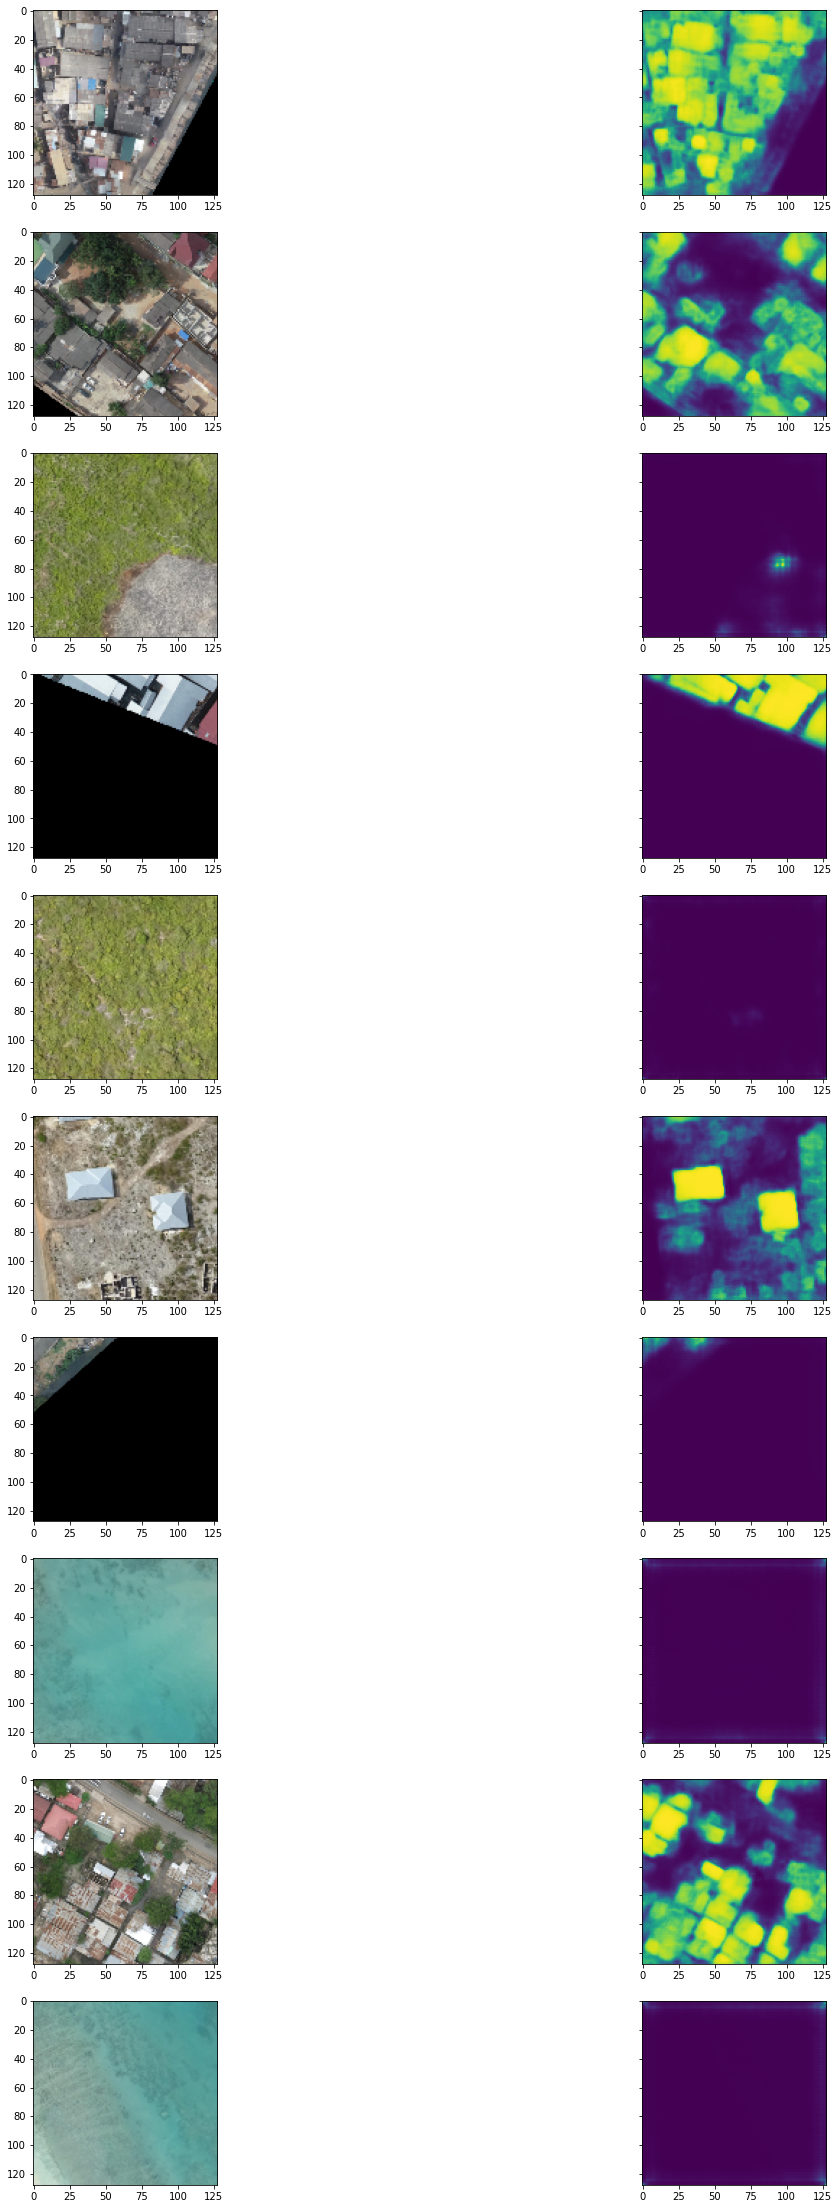

In [131]:
res = predict_and_show_random_images(model, 10)